In [1]:
# 모듈 불러오기
import os
import time
import copy
import random
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [13]:
random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [14]:
from torch.utils.data import Dataset, DataLoader, Subset
import torch

class TimeDataset(Dataset):
    def __init__(self, raw_data, window= 10,stride=1,mode='train'):
        self.raw_data = raw_data
        self.stride = stride
        self.window = window 
        self.mode = mode
        #raw_data = data
        y = raw_data.iloc[:,-1]
        raw_data = raw_data.iloc[:,:-2]
        
        data = torch.from_numpy(raw_data.values)
        
        data_y = torch.from_numpy(y.values)
        #data = torch.tensor(data).double()
        
        self.x, self.y = self.process(data,data_y)
    
    def __len__(self):
        return self.x.shape[0]
    
    def process(self,data,data_y) : 
        x_arr, y_arr = [], []

        is_train = self.mode == 'train'
        #is_train = True
        slide_win = self.window
        stride_win = self.stride
        total_time_len = len(data)
        
        rang = range(slide_win,total_time_len,stride_win) if is_train else range(slide_win,total_time_len)
        
        for i in rang :
#            i = 10
            ft = data[i-slide_win:i,:]
            x_arr.append(ft)
            
            label = data_y[i-slide_win:i]
            y_arr.append(label)
       
        x = torch.stack(x_arr).contiguous()
        y = torch.stack(y_arr).contiguous()
        
        
        return x , y
    
    def __getitem__(self, idx):
        feature = self.x[idx].float()
        label = self.y[idx].float()
        ## last value return
        feature = torch.transpose(feature,0,1)
        label = label[-1]
        return feature , label
    

In [15]:
import pandas as pd
import numpy as np

In [16]:
df = pd.read_csv('./230216_RawDataSet.csv', index_col=0)
df.columns = ['inlet','outlet','g','w']
#df['before'] = df['w'].shift(1)
#df['before'].iloc[0] = df['w'].iloc[0]

In [17]:
n_train = int(0.8 * len(df))
n_train

408

In [18]:
n_valid = int(0.9 * len(df))
n_valid

459

In [19]:
train_df = df.iloc[:n_train,:]
val_df = df.iloc[n_train:n_valid,:]
test_df = df.iloc[n_valid:,:]

In [20]:
train_dataset = TimeDataset(train_df,window=10)
val_dataset = TimeDataset(val_df,window=10)
test_dataset = TimeDataset(test_df,window=10)


In [21]:
from torch.utils.data import DataLoader, random_split, Subset

In [22]:
train_dataloader = DataLoader(train_dataset,batch_size=64,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=64,shuffle=False)
test_dataloader = DataLoader(test_dataset,batch_size=64,shuffle=False)

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim

#shape: (#실험자, dim 561, len 281)

In [24]:
# 1-dimensional convolution layer로 구성된 CNN 모델
# 2개의 1-dimensional convolution layer와 1개의 fully-connected layer로 구성되어 있음
class CNN_1D(nn.Module):
    def __init__(self, num_classes):
        super(CNN_1D, self).__init__()
        # 첫 번째 1-dimensional convolution layer 구축
        self.layer1 = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size=4),
            nn.Tanh(),
            nn.AvgPool1d(2)
        )
        # 두 번째 1-dimensional convolution layer 구축
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size=2),
            nn.Tanh(),
            nn.AvgPool1d(2)
        )
        # fully-connected layer 구축
        self.fc = nn.Linear(16 * 1, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [25]:
# 1D CNN 구축
device = 'cuda'
model = CNN_1D(num_classes=1)
model = model.to(device)
print(model)

CNN_1D(
  (layer1): Sequential(
    (0): Conv1d(2, 8, kernel_size=(4,), stride=(1,))
    (1): Tanh()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (layer2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(2,), stride=(1,))
    (1): Tanh()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (fc): Linear(in_features=16, out_features=1, bias=True)
)


In [26]:
# SGD optimizer 구축하기
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
num_epochs = 500

In [28]:
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    val_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            running_loss = 0.0
            running_corrects = 0
            running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                    #_, preds = torch.max(outputs, 1)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                running_loss += loss.item() 
                #running_corrects += torch.sum(preds == labels.data)
                running_total += labels.size(0)

            # epoch의 loss 및 accuracy 도출
            epoch_loss = running_loss / running_total
            #epoch_acc = running_corrects.double() / running_total

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
            if phase == 'val' and epoch_loss < best_loss:
                print(f'{epoch} : save_model')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_history.append(epoch_loss)

        print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)
    
    # best model 가중치 저장
    # torch.save(best_model_wts, '../output/best_model.pt')
    return model, val_history

In [29]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_dataloader,
    'val': val_dataloader
}

In [30]:
# loss function 설정
criterion = nn.MSELoss()

In [31]:
# 모델 학습
model, val_acc_history = train_model(model, dataloaders_dict, criterion, num_epochs, optimizer)

Epoch 1/500
----------


C:\Users\lee\anaconda3\envs\LG_DIC\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lee\anaconda3\envs\LG_DIC\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lee\anaconda3\envs\LG_DIC\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have th

train Loss: 0.2237
val Loss: 0.0932
0 : save_model

Epoch 2/500
----------
train Loss: 0.1926
val Loss: 0.0734
1 : save_model

Epoch 3/500
----------
train Loss: 0.1740
val Loss: 0.0564
2 : save_model

Epoch 4/500
----------
train Loss: 0.1554
val Loss: 0.0418
3 : save_model

Epoch 5/500
----------
train Loss: 0.1317
val Loss: 0.0296
4 : save_model

Epoch 6/500
----------
train Loss: 0.1154
val Loss: 0.0198
5 : save_model

Epoch 7/500
----------
train Loss: 0.1001
val Loss: 0.0124
6 : save_model

Epoch 8/500
----------
train Loss: 0.0878
val Loss: 0.0069
7 : save_model

Epoch 9/500
----------
train Loss: 0.0774
val Loss: 0.0033
8 : save_model

Epoch 10/500
----------
train Loss: 0.0654
val Loss: 0.0011
9 : save_model

Epoch 11/500
----------
train Loss: 0.0582
val Loss: 0.0003
10 : save_model

Epoch 12/500
----------
train Loss: 0.0505
val Loss: 0.0005

Epoch 13/500
----------
train Loss: 0.0497
val Loss: 0.0015

Epoch 14/500
----------
train Loss: 0.0420
val Loss: 0.0031

Epoch 15/500

In [32]:
model

CNN_1D(
  (layer1): Sequential(
    (0): Conv1d(2, 8, kernel_size=(4,), stride=(1,))
    (1): Tanh()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (layer2): Sequential(
    (0): Conv1d(8, 16, kernel_size=(2,), stride=(1,))
    (1): Tanh()
    (2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  )
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [33]:
def test_model(model,criterion, test_loader):
    model.eval()   # 모델을 validation mode로 설정
    
    # test_loader에 대하여 검증 진행 (gradient update 방지)
    with torch.no_grad():
        #corrects = 0
        total = 0
        label_list = []
        output_list = [] 
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # forward
            # input을 model에 넣어 output을 도출
            outputs = model(inputs)
            
            outputs = outputs.detach().cpu().numpy().tolist()
            output_list.extend(outputs)
            label_list.extend(labels.detach().cpu().numpy())
        
            
    return output_list, label_list

In [34]:
output_list,label_list = test_model(model, criterion, test_dataloader)

In [35]:
output_list

[[2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225],
 [2.4514100551605225]]

In [36]:
label_list

[2.304606,
 2.396678,
 2.466772,
 2.3624077,
 2.3153226,
 2.307558,
 2.4113579,
 2.4476678,
 2.4475827,
 2.2919137,
 2.2839155,
 2.30857,
 2.431437,
 2.3871229,
 2.3663397,
 2.4650793,
 2.4962463,
 2.5044162,
 2.4053051,
 2.4317226,
 2.384631,
 2.4047058,
 2.3639357,
 2.4228513,
 2.5234191,
 2.349637,
 2.430969,
 2.4822721,
 2.47304,
 2.435214,
 2.3145738,
 2.440728,
 2.2672696,
 2.2844753,
 2.4609153,
 2.5124917,
 2.4430888,
 2.5957258,
 2.4064314,
 2.1980708,
 2.4664056,
 2.375425]

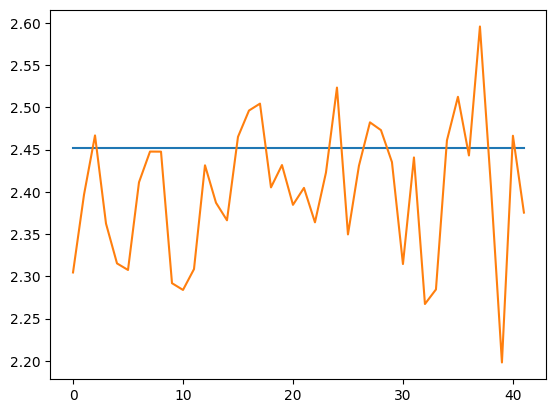

In [37]:
import matplotlib.pyplot as plt
plt.plot(output_list)
plt.plot(label_list)

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [39]:
mean_absolute_error(output_list,label_list)

0.07270169258117676

In [40]:
mean_squared_error(output_list,label_list)

0.008976688485055158